In [19]:
import pandas as pd
import os
import glob
import logging
from pathlib import Path
import itertools

In [20]:
# import file
file="G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\Consolidated2019Sales.csv"
df = pd.read_csv(file)

In [21]:
 # Create input and output directory
input_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\ProductCombinations')
output_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\ProductAnalysis')
output_dir.mkdir(parents=True, exist_ok=True) 

In [22]:
# Calculate revenue for each transaction
df['Revenue'] = (df['Quantity'] * df['UnitPrice']).round(2)
        

# 1. Overall Product Performance
product_summary = df.groupby('Product').agg({
            'Order ID': 'nunique',  # Number of orders
            'Quantity': 'sum',      # Total units sold
            'Revenue': 'sum',       # Total revenue
            'City': 'nunique'       # Number of cities sold in
        }).reset_index()
        
# Rename columns
product_summary = product_summary.rename(columns={
            'Order ID': 'Number of Orders',
            'Quantity': 'Total Units Sold',
            'City': 'Cities Sold In'
        })
        
# Calculate average metrics
product_summary['Average Order Size'] = (product_summary['Total Units Sold'] / 
                                               product_summary['Number of Orders']).round(2)
product_summary['Average Unit Revenue'] = (product_summary['Revenue'] / 
                                                 product_summary['Total Units Sold']).round(2)
product_summary['Average Order Revenue'] = (product_summary['Revenue'] / 
                                                  product_summary['Number of Orders']).round(2)
        
# Sort by revenue
product_summary = product_summary.sort_values('Revenue', ascending=False)
        
# Save detailed product summary
product_summary.to_csv(output_dir / 'product_performance_summary.csv', index=False)

In [23]:
# 2. Product Sales by City
city_product_summary = df.pivot_table(
            index='Product',
            columns='City',
            values='Quantity',
            aggfunc='sum',
            fill_value=0
        ).reset_index()
        
city_product_summary.to_csv(output_dir / 'product_sales_by_city.csv', index=False)
        
# 3. Monthly Product Performance
df['Month'] = pd.to_datetime(df['OrderDate']).dt.strftime('%Y-%m')
monthly_product = df.pivot_table(
            index='Product',
            columns='Month',
            values='Quantity',
            aggfunc='sum',
            fill_value=0
        ).reset_index()
        
monthly_product.to_csv(output_dir / 'monthly_product_sales.csv', index=False)
        
# 4. Product Correlations
product_correlations = df.pivot_table(
            index='Order ID',
            columns='Product',
            values='Quantity',
            aggfunc='sum',
            fill_value=0
        ).corr()
        
product_correlations.to_csv(output_dir / 'product_correlations.csv')
        

In [24]:
# Group orders to get product combinations
order_products = df.groupby('Order ID')['Product'].agg(list).reset_index()
        
# Function to get combinations and their frequencies
def get_combination_stats(combinations):
    combo_stats = []
    for combo in combinations:
        # Count orders containing this combination
        orders_with_combo = order_products['Product'].apply(
                    lambda x: all(item in x for item in combo)
                ).sum()
                
        if orders_with_combo > 0:
                    # Get all orders containing this combination
            combo_orders = df[df['Order ID'].isin(
                        order_products[order_products['Product'].apply(
                            lambda x: all(item in x for item in combo)
                        )]['Order ID']
                    )]
                    
            # Calculate statistics
            total_revenue = combo_orders['Revenue'].sum()
            avg_order_value = total_revenue / orders_with_combo
                    
            combo_stats.append({
                        'Combination': ' + '.join(combo),
                        'Number of Orders': orders_with_combo,
                        'Total Revenue': total_revenue,
                        'Average Order Value': avg_order_value,
                        'Products in Combination': len(combo)
                    })
            
    return pd.DataFrame(combo_stats)
        
   

In [25]:
 # Analyze 2-product combinations
product_pairs = list(itertools.combinations(df['Product'].unique(), 2))
pair_stats = get_combination_stats(product_pairs)
        
# Analyze 3-product combinations
product_triplets = list(itertools.combinations(df['Product'].unique(), 3))
triplet_stats = get_combination_stats(product_triplets)
        
# Sort by number of orders and filter for significant combinations
min_orders = 5  # Minimum number of orders to be considered significant
        
pair_stats = pair_stats[pair_stats['Number of Orders'] >= min_orders].sort_values('Number of Orders', ascending=False)
        
triplet_stats = triplet_stats[triplet_stats['Number of Orders'] >= min_orders].sort_values('Number of Orders', ascending=False)
        
# Save results
pair_stats.to_csv(output_dir / 'product_pairs_analysis.csv', index=False)
triplet_stats.to_csv(output_dir / 'product_triplets_analysis.csv', index=False)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Set style parameters
plt.style.use('default')
plt.rcParams.update({
            'figure.figsize': (15, 8),
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'axes.grid': True,
            'grid.alpha': 0.3,
            'font.family': 'sans-serif',
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16
        })

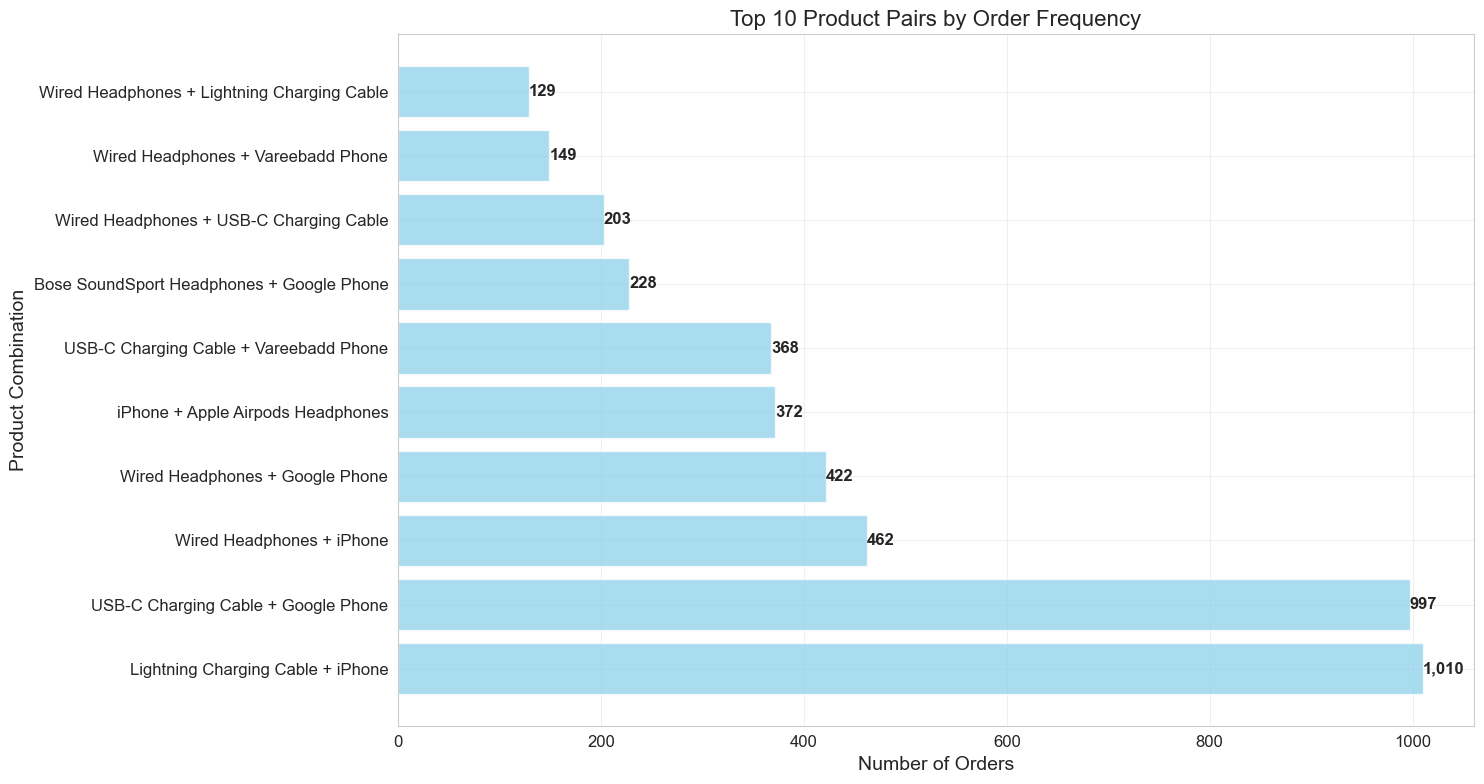

In [29]:
pair_stats = pd.read_csv(output_dir / 'product_pairs_analysis.csv')
triplet_stats = pd.read_csv(output_dir / 'product_triplets_analysis.csv')
        
        
# Set style parameters
plt.style.use('default')
plt.rcParams.update({
            'figure.figsize': (15, 8),
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'axes.grid': True,
            'grid.alpha': 0.3,
            'font.family': 'sans-serif',
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16
        })
        

        
# Set Seaborn style
sns.set_style("whitegrid")
        
# 1. Top 10 Product Pairs
plt.figure(figsize=(15, 8))
top_pairs = pair_stats.head(10)
bars = plt.barh(top_pairs['Combination'], top_pairs['Number of Orders'], 
                       color='skyblue', alpha=0.7)
plt.title('Top 10 Product Pairs by Order Frequency')
plt.xlabel('Number of Orders')
plt.ylabel('Product Combination')
        
# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,f'{int(width):,}',ha='left', va='center', fontweight='bold')
        
plt.tight_layout()
plt.savefig(output_dir / 'top_product_pairs.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
        

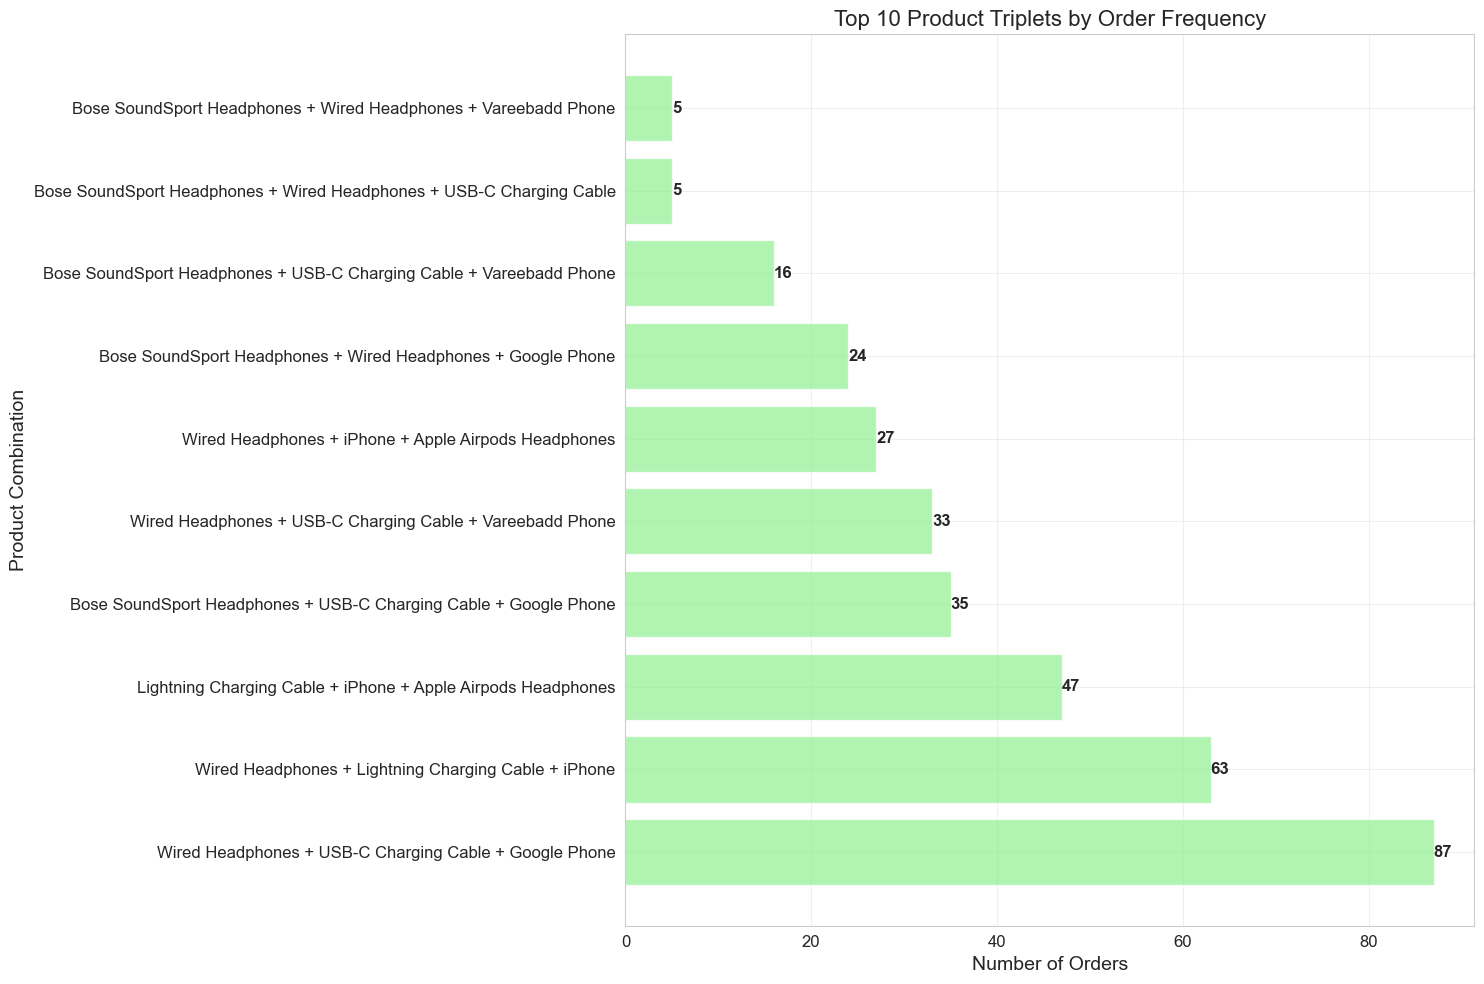

In [30]:
# 2. Top 10 Product Triplets
plt.figure(figsize=(15, 10))
top_triplets = triplet_stats.head(10)
bars = plt.barh(top_triplets['Combination'], top_triplets['Number of Orders'],
                       color='lightgreen', alpha=0.7)
plt.title('Top 10 Product Triplets by Order Frequency')
plt.xlabel('Number of Orders')
plt.ylabel('Product Combination')
        
# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
                    f'{int(width):,}', 
                    ha='left', va='center', fontweight='bold')
        
plt.tight_layout()
plt.savefig(output_dir / 'top_product_triplets.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
        

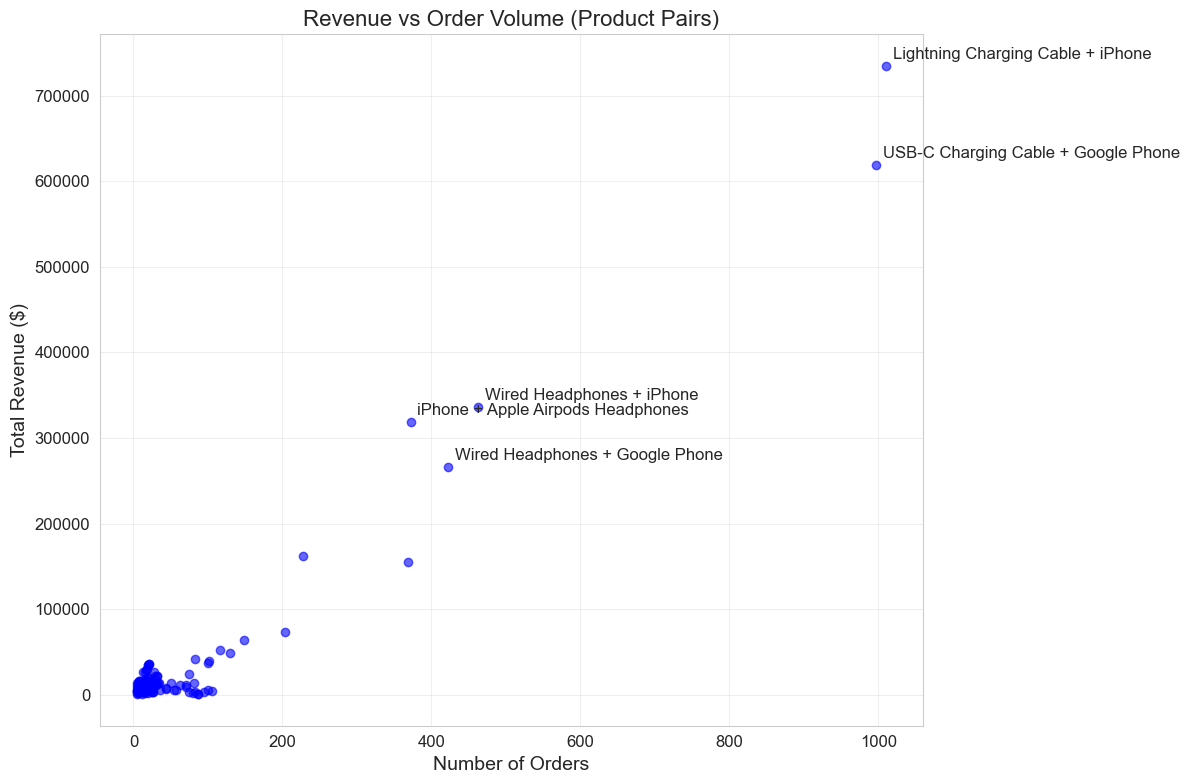

In [31]:
# 3. Revenue vs Orders Scatter Plot (Pairs)
plt.figure(figsize=(12, 8))
plt.scatter(pair_stats['Number of Orders'], pair_stats['Total Revenue'],
                   alpha=0.6, c='blue')
plt.title('Revenue vs Order Volume (Product Pairs)')
plt.xlabel('Number of Orders')
plt.ylabel('Total Revenue ($)')
        
# Add annotations for top 5 points
top_5_pairs = pair_stats.nlargest(5, 'Total Revenue')
for _, row in top_5_pairs.iterrows():
    plt.annotate(row['Combination'],
                        (row['Number of Orders'], row['Total Revenue']),
                        xytext=(5, 5), textcoords='offset points')
        
plt.tight_layout()
plt.savefig(output_dir / 'pairs_revenue_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
        


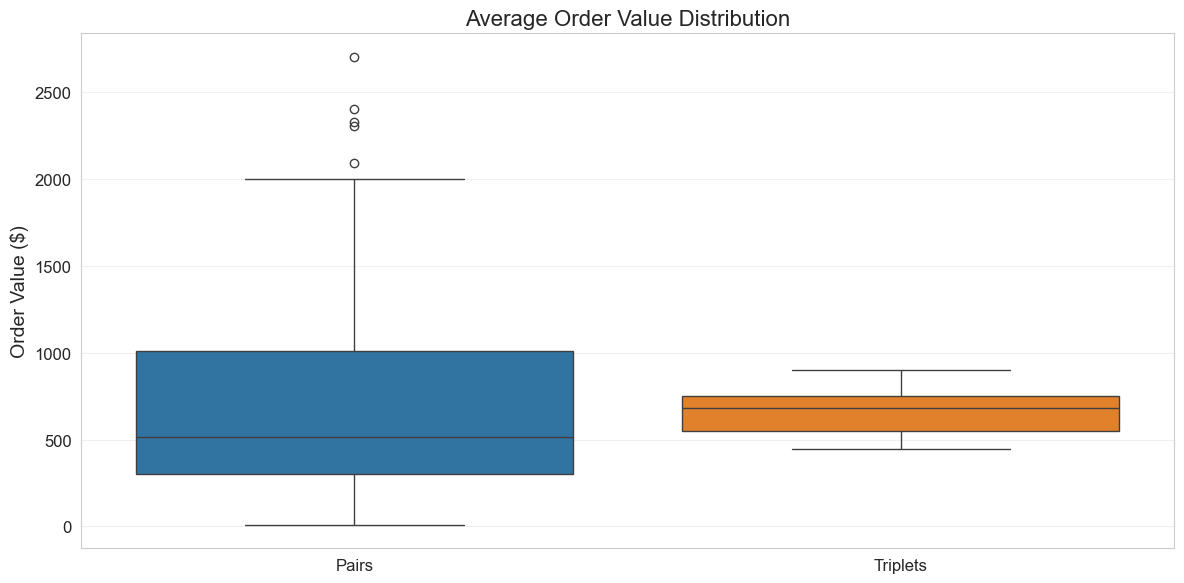

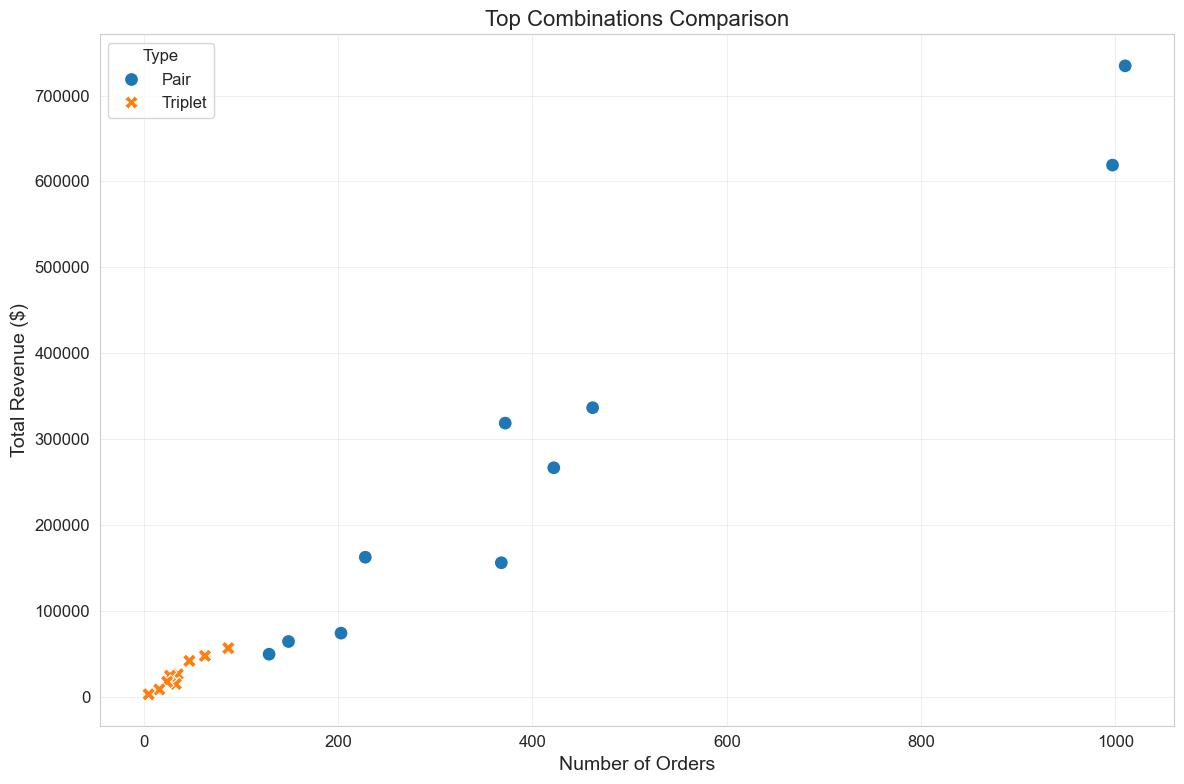

In [33]:
# 4. Average Order Value Comparison
plt.figure(figsize=(12, 6))
data = {
            'Pairs': pair_stats['Average Order Value'],
            'Triplets': triplet_stats['Average Order Value']
        }
sns.boxplot(data=data)
plt.title('Average Order Value Distribution')
plt.ylabel('Order Value ($)')
        
plt.tight_layout()
plt.savefig(output_dir / 'order_value_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
        
# 6. Top Combinations Matrix
plt.figure(figsize=(12, 8))
top_10_matrix = pd.DataFrame({
            'Combination': pd.concat([top_pairs['Combination'], top_triplets['Combination']]),
            'Orders': pd.concat([top_pairs['Number of Orders'], top_triplets['Number of Orders']]),
            'Revenue': pd.concat([top_pairs['Total Revenue'], top_triplets['Total Revenue']]),
            'Type': ['Pair']*10 + ['Triplet']*10
        })
        
sns.scatterplot(data=top_10_matrix, x='Orders', y='Revenue', 
                       hue='Type', style='Type', s=100)
plt.title('Top Combinations Comparison')
plt.xlabel('Number of Orders')
plt.ylabel('Total Revenue ($)')
        
plt.tight_layout()
plt.savefig(output_dir / 'top_combinations_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [34]:
input_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\ProductAnalysis')
product_summary = pd.read_csv(input_dir / 'product_performance_summary.csv')
city_product = pd.read_csv(input_dir / 'product_sales_by_city.csv')
monthly_sales = pd.read_csv(input_dir / 'monthly_product_sales.csv')
        
        
# Set style parameters
plt.style.use('default')
plt.rcParams.update({
            'figure.figsize': (15, 8),
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'axes.grid': True,
            'grid.alpha': 0.3,
            'font.family': 'sans-serif',
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16
        })
        
# Create output directory
output_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\Visualizations\\ProductPatterns')
output_dir.mkdir(parents=True, exist_ok=True)

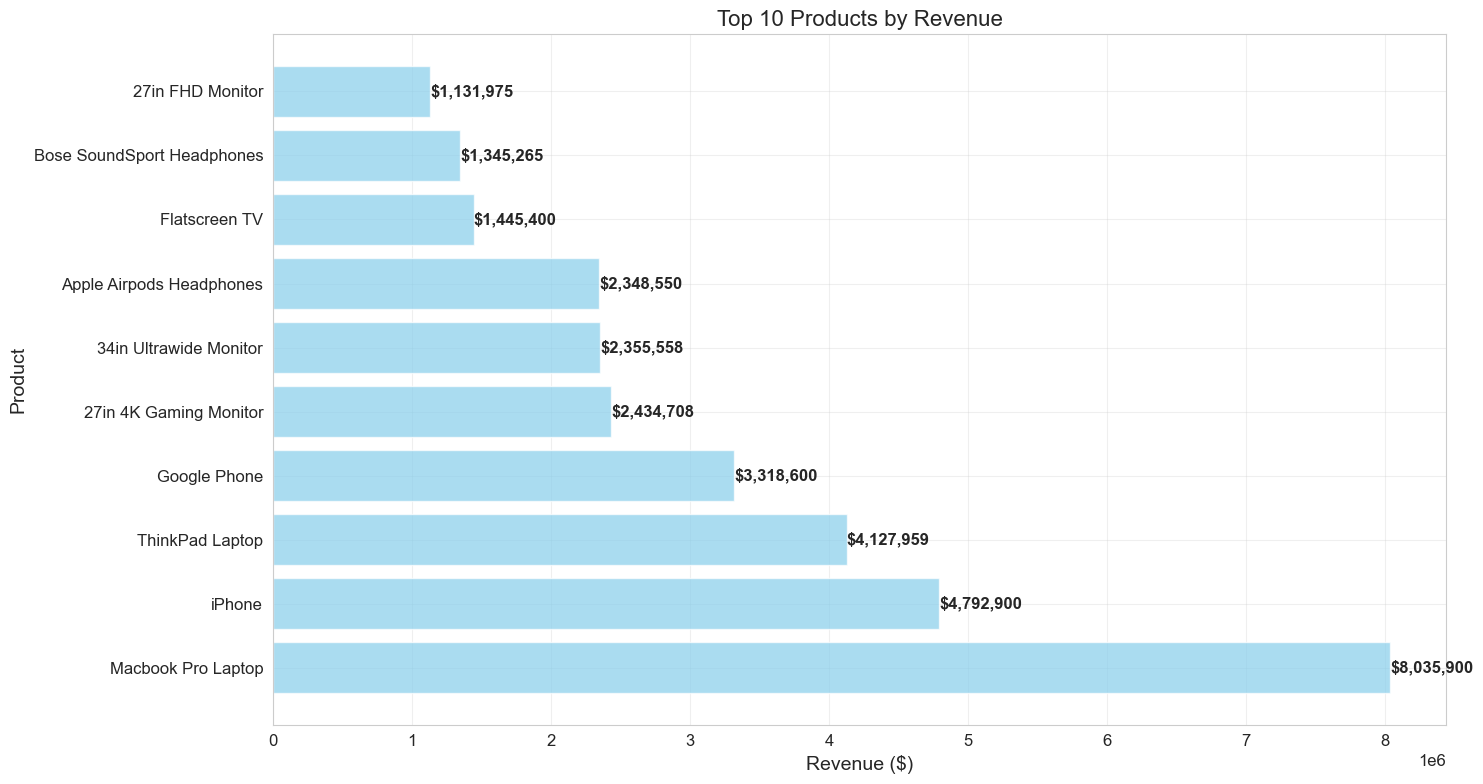

In [35]:
# Set Seaborn style
sns.set_style("whitegrid")
        
# 1. Top 10 Products by Revenue
plt.figure(figsize=(15, 8))
top_products = product_summary.nlargest(10, 'Revenue')
bars = plt.barh(top_products['Product'], top_products['Revenue'], 
                       color='skyblue', alpha=0.7)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Product')
        
# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
                    f'${width:,.0f}', 
                    ha='left', va='center', fontweight='bold')
        
plt.tight_layout()
plt.savefig(output_dir / 'top_products_revenue.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
        
       

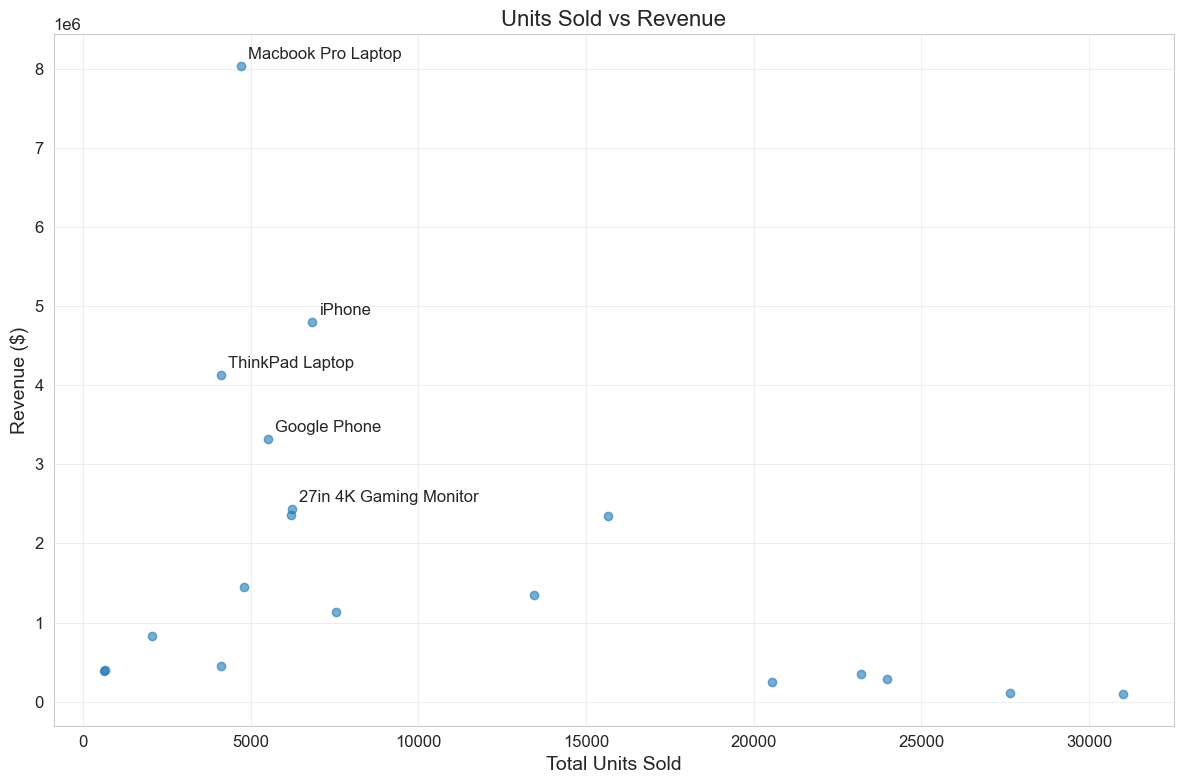

In [36]:
 # 2. Units Sold vs Revenue Scatter
plt.figure(figsize=(12, 8))
plt.scatter(product_summary['Total Units Sold'], 
                   product_summary['Revenue'],
                   alpha=0.6)
plt.title('Units Sold vs Revenue')
plt.xlabel('Total Units Sold')
plt.ylabel('Revenue ($)')
        
# Add annotations for top 5 products
top_5_revenue = product_summary.nlargest(5, 'Revenue')
for _, row in top_5_revenue.iterrows():
    plt.annotate(row['Product'],
                        (row['Total Units Sold'], row['Revenue']),
                        xytext=(5, 5), textcoords='offset points')
        
plt.tight_layout()
plt.savefig(output_dir / 'units_vs_revenue.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

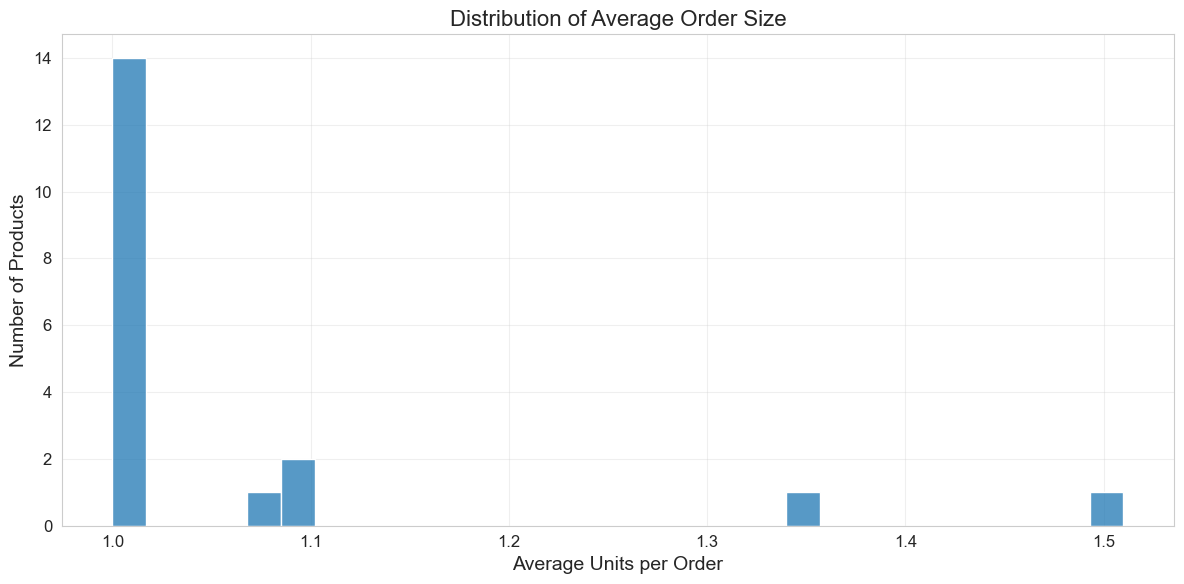

In [37]:
# 3. Average Order Size Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=product_summary, x='Average Order Size', bins=30)
plt.title('Distribution of Average Order Size')
plt.xlabel('Average Units per Order')
plt.ylabel('Number of Products')
plt.tight_layout()
plt.savefig(output_dir / 'order_size_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# 4. Monthly Sales Heatmap for Top Products
plt.figure(figsize=(15, 8))
top_10_products = product_summary.nlargest(10, 'Revenue')['Product']
monthly_heatmap = monthly_sales[monthly_sales['Product'].isin(top_10_products)]
monthly_heatmap = monthly_heatmap.set_index('Product')
        
sns.heatmap(monthly_heatmap, cmap='YlOrRd', 
                   annot=True, fmt='.0f',
                   cbar_kws={'label': 'Units Sold'})
plt.title('Monthly Sales Pattern - Top 10 Products')
plt.xlabel('Month')
plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(output_dir / 'monthly_sales_heatmap.png', dpi=300, bbox_inches='tight')
        plt.close()

In [ ]:
# 6. Revenue vs Average Order Value
plt.figure(figsize=(12, 8))
plt.scatter(product_summary['Average Order Revenue'],
                   product_summary['Revenue'],
                   alpha=0.6)
plt.title('Total Revenue vs Average Order Value')
plt.xlabel('Average Order Value ($)')
plt.ylabel('Total Revenue ($)')
        
# Add annotations for interesting points
top_5_avg_order = product_summary.nlargest(5, 'Average Order Revenue')
for _, row in top_5_avg_order.iterrows():
    plt.annotate(row['Product'],
                        (row['Average Order Revenue'], row['Revenue']),
                        xytext=(5, 5), textcoords='offset points')
        
plt.tight_layout()
plt.savefig(output_dir / 'revenue_vs_order_value.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()